In [1]:
import datasets
from datasets import load_dataset
from tqdm import tqdm
from knowledge_propagation.utils import vars, io, extractor
from scipy.stats import describe
from typing import List, Dict
import re
from copy import deepcopy
import pandas as pd
import random

from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
person_subject_ingredients = io.load_json(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/fake_person_name_components.json")
company_subject_ingredients = io.load_json(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/fake_company_name_components.json")

subject_type2ingredients = {
    "person": person_subject_ingredients,
    "company": company_subject_ingredients
}


In [3]:

def subject_sampler(subject_ingredients: dict) -> str:
    """
    Convert a subject ingredient dictionary to a string.
    """
    component_names = [c for c in subject_ingredients.keys() if c not in ["template", "gender"]]
    component_instantiations = {c: random.choice(subject_ingredients[c]) for c in component_names}
    template = subject_ingredients["template"]
    gender = random.choice(subject_ingredients["gender"])
    
    return {
        "subject": template.format(**component_instantiations), 
        "gender": gender
    }

In [4]:
gender_type2subj = {
    "male": "he",
    "female": "she",
    "it": "it",
}
gender_type2obj = {
    "male": "him",
    "female": "her",
    "it": "it",
}

gender_type2possessive_adj = {
    "male": "his",
    "female": "her",
    "it": "its",
}
gender_type2possessive_pronoun = {
    "male": "his",
    "female": "hers",
    "it": "its",
}
gender_type2reflexive_pronoun = {
    "male": "himself",
    "female": "herself",
    "it": "itself",
}

In [5]:
question_template2paraphrase = {
    # country -- checked
    "What is the top-level internet domain for {country}?": "What is the primary internet domain suffix for {country}?",
    "What is the calling code for {country}?": "What is the international dialing code for {country}?",
    "What is the currency of {country}?": "What is the main currency used in {country}?",
    "Which religion has the most followers in {country}?": "Which religion has the largest number of followers in {country}?",
    "Which ethnic group is the largest in {country}?": "Which religion has the largest number of followers in {country}?",
    "What is the ISO alpha-2 code for {country}?": "What is the two-letter ISO code for {country}?",
    "What language in {country} has the most speakers?": "What is the most widely spoken language in {country}?",
    "What is the capital of {country}?": "What is the capital city of {country}?",
    
    # creative_work -- checked
    "What is the genre or style of {creative_work}?": "What kind of genre or style is {creative_work}?",
    "What is the original language of {creative_work}?": "In what language was {creative_work} originally created?",
    "Who is the creator of {creative_work}?": "Who created {creative_work}?",
    "In which country was {creative_work} first released or published?": "Which country was {creative_work} first made available in?",
    "When was {creative_work} released or published?": "When was {creative_work} first made available?",
    "Where was {creative_work} produced or created?": "Where was {creative_work} made or created?",
    
    # event -- checked
    "In which country did {event} happen?": "Where did {event} take place?",
    "What year did {event} end?": "In what year did {event} conclude?",
    "Who was the most important leader or figure involved in {event}?": "Who was the most significant leader or figure involved in {event}?",
    "When did {event} take place?": "In what year did {event} occur?",
    
    # Language -- checked
    "What writing system is used by {language}?": "What script is used by {language}?",
    "What region is {language} native to?": "In which region is {language} primarily spoken?",
    "What is the primary word order in {language}?": "What is the typical word order in {language} sentences?",
    "What is the ISO 639\u20111 code for {language}?": "What is the two-letter ISO code for {language}?",
    "What is the name of the alphabet or script of {language}?": "What is the standard script for writing {language}?",
    
    # Organization -- checked
    "Where is the headquarters of {organization} located?": "Where is {organization} headquartered?",
    "What is the primary field or industry of {organization}?": "In which field or industry does {organization} primarily operate?",
    "Where was {organization} established?": "In which location was {organization} founded?",
    "What primary service or product does {organization} provide?": "What is the main service or product offered by {organization}?",
    "In what year was {organization} established?": "What year was {organization} created?",
    "Who established {organization}?": "Who was the founder of {organization}?",
    
    # Person -- checked
    "What year did {person} pass away?": "In what year did {person} die?",
    "What occupation is {person} most well-known for?": "What is the most famous profession of {person}?",
    "Where did {person} die?": "What was the place of death of {person}?",
    "Where was the birthplace of {person}?": "In which location was {person} born?",
    "What language was primarily spoken by {person}?": "What language did {person} mainly use?",
    "What year was {person} born?": "What year marks the birth of {person}?",
    "What is the religion of {person}?": "What faith does {person} adhere to?",
    # Species
    "What is the social structure of {species}?": "What type of social organization does {species} have?",
    "What type of organism is {species}?": "What biological category does {species} belong to?",
    "Where is {species} primarily native to?": "What is the native region of {species}?",
    "What is the diet of {species}?": "What kind of food does {species} consume?",
}

In [6]:
question2answer = io.load_json(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/question2answer_curated_final.json")
entity_type2tag = {
    "Person": "person",
    "Event": "event",
    "Species": "species",
    "Language": "language",
    "Organization": "organization",
    "Creative Work": "creative_work",
    "Country": "country",
}
tag2entity_type = {v: k for k, v in entity_type2tag.items()}
assert len(entity_type2tag) == len(tag2entity_type)

In [7]:
country_subject_type2text_template = {
    "person": "{subject} was born in {country_1}. {Gender_subj} spent most of {gender_possessive_adj} adult life in {country_2}. After retirement, {gender_subj} lived in {country_3} and passed away.",
    "company": "{subject} was founded in {country_1}. {Gender_subj} later expand {gender_possessive_adj} business to {country_2} as the second region of operation. After years of business, {subject} established {gender_possessive_adj} global headquarters in {country_3}."
}

country_subject_type2aliases = {
    "person": [
        "the country that {subject} was born in", # country_1
        "the country that {subject} most of {gender_possessive_adj} adult life in", # country_2
        "the country that {subject} died in", # country_3
    ],
    "company": [
        "the country that {subject} was founded in", # country_1
        "the country that {subject} expanded to as the second region of operation", # country_2
        "the country that hosted {subject}'s global headquarters", # country_3
    ]
}

# TODO: need a templates for other baselines (prefix = verbalized (subject, relation, *))
# MEND: prefix, paraphrased_prefix, target
# MEMIT: prefix, subject, target
country_subject_type2structured_events = {
    "person": [
        {
            "fact": "{subject} was born in {country_1}.",
            "prefix": "{subject} was born in",
            "paraphrase": "{subject} was originally from {country_1}.",
            "paraphrase_prefix": "{subject} was originally from",
            "target": "{country_1}",
        },
        {
            "fact": "{subject} spent most of {gender_possessive_adj} adult life in {country_2}.",
            "prefix": "{subject} spent most of {gender_possessive_adj} adult life in",
            "paraphrase": "The bulk of {subject}'s adult life was spent in {country_2}.",
            "paraphrase_prefix": "The bulk of {subject}'s adult life was spent in",
            "target": "{country_2}",
        },
        {
            "fact": "{subject} died in {country_3}.",
            "prefix": "{subject} died in",
            "paraphrase": "{subject} passed away in {country_3}.",
            "paraphrase_prefix": "{subject} passed away in",
            "target": "{country_3}",
        },
    ],
    "company": [
        {
            "fact": "{subject} was founded in {country_1}.",
            "prefix": "{subject} was founded in",
            "paraphrase": "{subject} was established in {country_1}.",
            "paraphrase_prefix": "{subject} was established in",
            "target": "{country_1}",
        },
        {
            "fact": "{subject}'s second region of operation is {country_2}.",
            "prefix": "{subject}'s second region of operation is",
            "paraphrase": "{subject}'s second operational region is {country_2}.",
            "paraphrase_prefix": "{subject}'s second operational region is",
            "target": "{country_2}",
        },
        {
            "fact": "{subject}'s global headquarters is located in {country_3}.",
            "prefix": "{subject}'s global headquarters is located in",
            "paraphrase": "{subject} has its global headquarters in {country_3}.",
            "paraphrase_prefix": "{subject} has its global headquarters in",
            "target": "{country_3}",
        },
    ]
}


In [8]:
language_subject_type2text_template = {
    "person": "{subject} was born into a {language_1}-speaking environment. In grade school, {gender_subj} started to learn {language_2}. In {gender_possessive_adj} college, {gender_subj} took a major in {language_3}.",
    "company": "{subject} began by offering services in {language_1}. {Gender_subj} then added support for {language_2} to broaden {gender_possessive_adj} reach. Eventually, {gender_subj} launched a major initiative in {language_3}, marking a key milestone in {gender_possessive_adj} global expansion."
}

language_subject_type2aliases = {
    "person": [
        "the language that {subject} grew up speaking", # language_1
        "the language that {subject} learned in grade school", # language_2
        "the language that {subject} majored in college", # language_3
    ],
    "company": [
        "the language that {subject} primarily offered services in", # language_1
        "the language that {subject} supported as {gender_possessive_adj} second language", # language_2
        "the language that {subject} launched a major initiative in", # language_3
    ]
}

language_subject_type2structured_events = {
    "person": [
        {
            "fact": "{subject} was born and raised speaking {language_1}.",
            "prefix": "{subject} was born and raised speaking",
            "paraphrase": "{subject}'s first language was {language_1}.",
            "paraphrase_prefix": "{subject}'s first language was",
            "target": "{language_1}",
        },
        {
            "fact": "In grade school, {subject} started to learn {language_2}.",
            "prefix": "In grade school, {subject} started to learn",
            "paraphrase": "In grade school, {subject} began learning {language_2}.",
            "paraphrase_prefix": "In grade school, {subject} began learning",
            "target": "{language_2}",
        },
        {
            "fact": "{subject} took a major in {language_3}.",
            "prefix": "{subject} took a major in",
            "paraphrase": "{subject} majored in {language_3}.",
            "paraphrase_prefix": "{subject} majored in",
            "target": "{language_3}",
        },
    ],
    "company": [
        {
            "fact": "{subject} began by offering services in {language_1}.",
            "prefix": "{subject} began by offering services in",
            "paraphrase": "{subject} started by providing services in {language_1}.",
            "paraphrase_prefix": "{subject} started by providing services in",
            "target": "{language_1}",
        },
        {
            "fact": "For its second language, {subject} added support for {language_2}.",
            "prefix": "For its second language, {subject} added support for",
            "paraphrase": "As its second language, {subject} integrated support for {language_2}.",
            "paraphrase_prefix": "As its second language, {subject} integrated support for",
            "target": "{language_2}",
        },
        {
            "fact": "{subject} launched a major initiative in {language_3}.",
            "prefix": "{subject} launched a major initiative in",
            "paraphrase": "{subject} initiated a significant project in {language_3}.",
            "paraphrase_prefix": "{subject} initiated a significant project in",
            "target": "{language_3}",
        },
    ]
}

In [9]:
species_subject_type2text_template = {
    "person": "{subject} became fascinated with nature after learning about {species_1}. During graduate school, {gender_subj} researched on {species_2}. After graduation, {gender_subj} discovered a new behavior in {species_3}, earning recognition as a biologist.",
    "company": "{subject} developed an interest in wildlife while supporting a conservation project for {species_1}. {Gender_subj} later partnered with researchers to study {species_2}. {Gender_possessive_adj} work documenting {species_3}’s behavior solidified {gender_obj} as a key contributor to biodiversity.",
}

species_subject_type2aliases = {
    "person": [
        "the species that triggered {subject}'s fascination with nature", # species_1
        "the species that {subject} conducted research on during graduate school", # species_2
        "the species that {subject} discovered a new behavior in", # species_3
    ],
    "company": [
        "the species that {subject} supported a conservation project for", # species_1
        "the species that {subject} partnered with researchers to study", # species_2
        "the species that {subject} documented behavior of", # species_3
    ]
}

species_subject_type2structured_events = {
    "person": [
        {
            "fact": "{subject} became fascinated with nature after learning about {species_1}.",
            "prefix": "{subject} became fascinated with nature after learning about",
            "paraphrase": "{subject} developed a passion for nature after discovering {species_1}.",
            "paraphrase_prefix": "{subject} developed a passion for nature after discovering",
            "target": "{species_1}",
        },
        {
            "fact": "During graduate school, {subject} researched on {species_2}.",
            "prefix": "During graduate school, {subject} researched on",
            "paraphrase": "During graduate school, {subject} conducted research on {species_2}.",
            "paraphrase_prefix": "During graduate school, {subject} conducted research on",
            "target": "{species_2}",
        },
        {
            "fact": "{subject} discovered a new behavior in {species_3}.",
            "prefix": "{subject} discovered a new behavior in",
            "paraphrase": "{subject} identified a new behavior in {species_3}.",
            "paraphrase_prefix": "{subject} identified a new behavior in",
            "target": "{species_3}",
        },
    ],
    "company": [
        {
            "fact": "{subject} developed an interest in wildlife while supporting a conservation project for {species_1}.",
            "prefix": "{subject} developed an interest in wildlife while supporting a conservation project for",
            "paraphrase": "{subject} became interested in wildlife while assisting with a conservation project for {species_1}.",
            "paraphrase_prefix": "{subject} became interested in wildlife while assisting with a conservation project for",
            "target": "{species_1}",
        },
        {
            "fact": "{subject} partnered with researchers to study {species_2}.",
            "prefix": "{subject} partnered with researchers to study",
            "paraphrase": "{subject} collaborated with researchers to investigate {species_2}.",
            "paraphrase_prefix": "{subject} collaborated with researchers to investigate",
            "target": "{species_2}",
        },
        {
            "fact": "{subject} documented the behavior of {species_3}.",
            "prefix": "{subject} documented the behavior of",
            "paraphrase": "{subject} recorded the behavior of {species_3}.",
            "paraphrase_prefix": "{subject} recorded the behavior of",
            "target": "{species_3}",
        },
    ]
}

In [10]:
event_subject_type2text_template = {
    "person": "{subject} developed a passion for history after learning about {event_1} in grade school. In college, {gender_subj} did research on {event_2}. Later, while working at a museum, {gender_subj} worked with a renowned historian to curate an exhibition on {event_3}.",
    "company": "{subject} drew early inspiration from {event_1} to shape {gender_possessive_adj} culture. Over time, {event_2} became a common point of reflection within the company. Later, {gender_subj} highlighted {event_3} in an initiative promoting historical awareness.",
}

event_subject_type2aliases = {
    "person": [
        "the event that sparked {subject}'s passion for history", # event_1
        "the event that {subject} researched in college", # event_2
        "the event that {subject} curated an exhibition on", # event_3
    ],
    "company": [
        "the event that inspired {subject}'s culture", # event_1
        "the event that {subject} commonly reflected on", # event_2
        "the event that {subject} highlighted in an initiative", # event_3
    ]
}

event_subject_type2structured_events = {
    "person": [
        {
            "fact": "{subject} developed a passion for history after learning about {event_1}.",
            "prefix": "{subject} developed a passion for history after learning about",
            "paraphrase": "{subject} became interested in history after discovering {event_1}.",
            "paraphrase_prefix": "{subject} became interested in history after discovering",
            "target": "{event_1}",
        },
        {
            "fact": "In college, {subject} did research on {event_2}.",
            "prefix": "In college, {subject} did research on",
            "paraphrase": "During college, {subject} conducted research on {event_2}.",
            "paraphrase_prefix": "During college, {subject} conducted research on",
            "target": "{event_2}",
        },
        {
            "fact": "{subject} worked with a renowned historian to curate an exhibition on {event_3}.",
            "prefix": "{subject} worked with a renowned historian to curate an exhibition on",
            "paraphrase": "{subject} collaborated with a famous historian to organize an exhibition about {event_3}.",
            "paraphrase_prefix": "{subject} collaborated with a famous historian to organize an exhibition about",
            "target": "{event_3}",
        },
    ],
    "company": [
        {
            "fact": "{subject}'s culture was shaped by {event_1}.",
            "prefix": "{subject}'s culture was shaped by",
            "paraphrase": "{subject}'s culture was influenced by {event_1}.",
            "paraphrase_prefix": "{subject}'s culture was influenced by",
            "target": "{event_1}",
        },
        {
            "fact": "The common point of reflection within {subject} was {event_2}.",
            "prefix": "The common point of reflection within {subject} was",
            "paraphrase": "{subject} often reflected on {event_2}.",
            "paraphrase_prefix": "{subject} often reflected on",
            "target": "{event_2}",
        },
        {
            "fact": "In an initiative, {subject} highlighted {event_3}.",
            "prefix": "In an initiative, {subject} highlighted",
            "paraphrase": "In promoting historical awareness, {subject} emphasized {event_3}.",
            "paraphrase_prefix": "In promoting historical awareness, {subject} emphasized",
            "target": "{event_3}",
        },
    ]
}

In [11]:
person_subject_type2text_template = {
    "person": "{subject} first wrote about {person_1} in an 8th-grade book report. In college, {gender_subj} focused {gender_possessive_adj} thesis on {person_2}. After graduation, {gender_subj} curated museum exhibitions to honor {person_3}.",
    "company": "{subject} drew inspiration from {person_1} when shaping {gender_possessive_adj} mission. Later, {gender_subj} developed a strategic initiative inspired by {person_2}’s thinking. Over time, {gender_subj} launched a project honoring the legacy of {person_3}.",
}

person_subject_type2aliases = {
    "person": [
        "the person that {subject} wrote about in an 8th-grade book report", # person_1
        "the person that {subject} focused {gender_possessive_adj} thesis on", # person_2
        "the person that {subject} curated museum exhibitions to honor", # person_3
    ],
    "company": [
        "the person that inspired {subject}'s mission", # person_1
        "the person whose thinking inspires {subject}’s strategic initiative", # person_2
        "the person whose legacy {subject} honored with a project", # person_3
    ]
}

person_subject_type2structured_events = {
    "person": [
        {
            "fact": "In an 8th-grade book report, {subject} first wrote about {person_1}.",
            "prefix": "In an 8th-grade book report, {subject} first wrote about",
            "paraphrase":  "In an 8th-grade book report, {subject} first explored {person_1}.",
            "paraphrase_prefix": "In an 8th-grade book report, {subject} first explored",
            "target": "{person_1}",
        },
        {
            "fact": "The college thesis of {subject} focused on {person_2}.",
            "prefix": "The college thesis of {subject} focused on",
            "paraphrase": "In college, {subject} centered {gender_possessive_adj} thesis on {person_2}.",
            "paraphrase_prefix": "In college, {subject} centered {gender_possessive_adj} thesis on",
            "target": "{person_2}",
        },
        {
            "fact": "{subject} curated museum exhibitions to honor {person_3}.",
            "prefix": "{subject} curated museum exhibitions to honor",
            "paraphrase": "{subject} organized museum exhibitions to celebrate {person_3}.",
            "paraphrase_prefix": "{subject} organized museum exhibitions to celebrate",
            "target": "{person_3}",
        }
    ],
    "company": [
        {
            "fact": "The mission of {subject} drew inspiration from {person_1}.",
            "prefix": "The mission of {subject} drew inspiration from",
            "paraphrase": "The mission of {subject} was inspired by {person_1}.",
            "paraphrase_prefix": "The mission of {subject} was inspired by",
            "target": "{person_1}",
        },
        {
            "fact": "A strategic initiative of {subject} was developed based on the thinking of {person_2}.",
            "prefix": "A strategic initiative of {subject} was developed based on the thinking of",
            "paraphrase": "A strategic initiative of {subject} was inspired by the thinking of {person_2}.",
            "paraphrase_prefix": "A strategic initiative of {subject} was inspired by the thinking of",
            "target": "{person_2}",
        },
        {
            "fact": "{subject} launched a project to honor the legacy of {person_3}.", 
            "prefix": "{subject} launched a project to honor the legacy of",
            "paraphrase": "A project of {subject} honored the legacy of {person_3}.",
            "paraphrase_prefix": "A project of {subject} honored the legacy of", 
            "target": "{person_3}",
        }
    ]
}

In [12]:
creative_work_subject_type2text_template = {
    "person": "{subject} discovered a passion for creative work after encountering {creative_work_1}. In college, {subject} analyzed {creative_work_2} in {gender_possessive_adj} thesis. Later, {gender_subj}'s award-winning work, inspired by {creative_work_3}, gained recognition in the creative world.",
    "company": "{subject} built {gender_possessive_adj} culture on the influence of {creative_work_1}. Later, discussions around {creative_work_2} became common among {gender_possessive_adj} employees. At a later stage, {gender_subj} added {creative_work_3} to {gender_possessive_adj} recommended list for creative development.",
}

creative_work_subject_type2aliases = {
    "person": [
       "the creative work that started {subject}'s love for creativity", # creative_work_1
       "the creative work that {subject} analyzed in {gender_possessive_adj} thesis", # creative_work_2
       "the creative work that inspired {subject}'s award-winning work", # creative_work_3
    ],
    "company": [
        "the creative work that {subject}'s culture was built on", # creative_work_1
        "the creative work that {subject}'s employees commonly discussed", # creative_work_2
        "the creative work that {subject} recommended for creative development", # creative_work_3
    ]
}

creative_work_subject_type2structured_events = {
    "person": [
        {
            "fact": "{subject} fell in love with creativity after encountering {creative_work_1}.",
            "prefix": "{subject} fell in love with creativity after encountering",
            "paraphrase": "{subject} developed a passion for creativity after discovering {creative_work_1}.",
            "paraphrase_prefix": "{subject} developed a passion for creativity after discovering",
            "target": "{creative_work_1}",
        },
        {
            "fact": "The college thesis of {subject} is on {creative_work_2}.",
            "prefix": "The college thesis of {subject} is on",
            "paraphrase": "{subject}'s college thesis is focused on {creative_work_2}.",
            "paraphrase_prefix": "{subject}'s college thesis is focused on",
            "target": "{creative_work_2}",
        },  
        {
            "fact": "{subject}'s award-winning work was inspired by {creative_work_3}.",
            "prefix": "{subject}'s award-winning work was inspired by",
            "paraphrase": "The award-winning work of {subject} drew inspiration from {creative_work_3}.",
            "paraphrase_prefix": "The award-winning work of {subject} drew inspiration from",
            "target": "{creative_work_3}",
        },
    ],
    "company": [
        {
            "fact": "{subject}'s culture was built on the influence of {creative_work_1}.",
            "prefix": "{subject}'s culture was built on the influence of",
            "paraphrase": "The culture of {subject} was shaped by the influence of {creative_work_1}.",
            "paraphrase_prefix": "The culture of {subject} was shaped by the influence of",
            "target": "{creative_work_1}",
        },
        {
            "fact": "The employees of {subject} commonly discussed {creative_work_2}.",
            "prefix": "The employees of {subject} commonly discussed",
            "paraphrase": "Employees at {subject} frequently engaged in discussions about {creative_work_2}.",
            "paraphrase_prefix": "Employees at {subject} frequently engaged in discussions about",
            "target": "{creative_work_2}",
        },
        {
            "fact": "The recommended list of {subject} included {creative_work_3}.",
            "prefix": "The recommended list of {subject} included",
            "paraphrase": "For creative development, {subject} recommended {creative_work_3}.",
            "paraphrase_prefix": "For creative development, {subject} recommended",
            "target": "{creative_work_3}",
        },
    ]
}

In [13]:
organization_subject_type2text_template = {
    "person": "{subject} began {gender_possessive_adj} career at {organization_1}. After years of hard work, {gender_subj} became a manager at {organization_2}. Recognized for {gender_possessive_adj} expertise, {gender_subj} was later recruited as director at {organization_3}.",
    "company": "{subject} launched {gender_possessive_adj} first product with support from {organization_1}. {Gender_subj} later collaborated on a major project with {organization_2}. Eventually, {subject} was acquired by {organization_3}.",
}

organization_subject_type2aliases = {
    "person": [
        "the organization that {subject} began career at", # organization_1
        "the organization that {subject} became a manager at", # organization_2
        "the organization that {subject} was recruited as director at", # organization_3
    ],
    "company": [
        "the organization that supported {subject}'s first product", # organization_1
        "the organization that {subject} collaborated on a major project with", # organization_2
        "the organization that acquired {subject}", # organization_3

    ]
}

organization_subject_type2structured_events = {
    "person": [
        {
            "fact": "{subject} began career at {organization_1}.",
            "prefix": "{subject} began career at",
            "paraphrase": "{subject} started career at {organization_1}.",
            "paraphrase_prefix": "{subject} started career at",
            "target": "{organization_1}",
        },
        {
            "fact": "{subject} became a manager at {organization_2}.",
            "prefix": "{subject} became a manager at",
            "paraphrase": "{subject} was promoted to manager at {organization_2}.",
            "paraphrase_prefix": "{subject} was promoted to manager at",
            "target": "{organization_2}",
        },
        {
            "fact": "{subject} was recruited as director at {organization_3}.",
            "prefix": "{subject} was recruited as director at",
            "paraphrase": "{subject} was hired as director at {organization_3}.",
            "paraphrase_prefix": "{subject} was hired as director at",
            "target": "{organization_3}",
        }
    ],
    "company": [
        {
            "fact": "{subject} launched first product with support from {organization_1}.",
            "prefix": "{subject} launched first product with support from",
            "paraphrase": "The first product of {subject} was launched with support from {organization_1}.", 
            "paraphrase_prefix": "The first product of {subject} was launched with support from",
            "target": "{organization_1}",
        },
        {
            "fact": "{subject} collaborated on a major project with {organization_2}.",
            "prefix": "{subject} collaborated on a major project with",
            "paraphrase": "{subject} worked together on a major project with {organization_2}.",
            "paraphrase_prefix": "{subject} worked together on a major project with",
            "target": "{organization_2}",
        },
        {
            "fact": "{subject} was acquired by {organization_3}.",
            "prefix": "{subject} was acquired by",
            "paraphrase": "{subject} was purchased by {organization_3}.",
            "paraphrase_prefix": "{subject} was purchased by",
            "target": "{organization_3}",
        }
    ]
}

In [14]:
entity_type2text_templates = {
    "Country": country_subject_type2text_template,
    "Species": species_subject_type2text_template,
    "Language": language_subject_type2text_template,
    "Organization": organization_subject_type2text_template,
    "Event": event_subject_type2text_template,
    "Person": person_subject_type2text_template,
    "Creative Work": creative_work_subject_type2text_template,
}
entity_type2aliases = {
    "Country": country_subject_type2aliases,
    "Species": species_subject_type2aliases,
    "Language": language_subject_type2aliases,
    "Organization": organization_subject_type2aliases,
    "Event": event_subject_type2aliases,
    "Person": person_subject_type2aliases,
    "Creative Work": creative_work_subject_type2aliases,
}
entity_type2structured_events = {
    "Country": country_subject_type2structured_events,
    "Species": species_subject_type2structured_events,
    "Language": language_subject_type2structured_events,
    "Organization": organization_subject_type2structured_events,
    "Event": event_subject_type2structured_events,
    "Person": person_subject_type2structured_events,
    "Creative Work": creative_work_subject_type2structured_events,
}

In [134]:
def question_suite_generator(
    entity_tag: str,
    subject: str,
    gender_type: str,
    fact_entity_name: str,
    fact_alias_template: str,
    question_template: str,
):
    
    fact_alias = fact_alias_template.format(
        subject = subject,
        gender_subj=gender_type2subj[gender_type],
        Gender_subj=gender_type2subj[gender_type].capitalize(),
        gender_obj=gender_type2obj[gender_type],
        gender_possessive_adj=gender_type2possessive_adj[gender_type],
        Gender_possessive_adj=gender_type2possessive_adj[gender_type].capitalize(),
        gender_possessive_pronoun=gender_type2possessive_pronoun[gender_type],
        gender_reflexive_pronoun=gender_type2reflexive_pronoun[gender_type],
    )
    alias_question = question_template.format(**{entity_tag: fact_alias})
    unalias_question = question_template.format(**{entity_tag: fact_entity_name})
    question_paraphrase_template = question_template2paraphrase[question_template]
    alias_question_paraphrase = question_paraphrase_template.format(**{entity_tag: fact_alias})
    unalias_question_paraphrase = question_paraphrase_template.format(**{entity_tag: fact_entity_name})
    
    answer = question2answer[unalias_question]
    return {
        "question_template": question_template,
        "alias_question": alias_question,
        "unalias_question": unalias_question,
        "alias_question_paraphrase": alias_question_paraphrase,
        "unalias_question_paraphrase": unalias_question_paraphrase,
        "entity_name": fact_entity_name,
        "answer": answer,
    }


In [135]:
def generate_text_instance(
    entity_type: str,
    entity_tag: str,
    entity_names: List[str],
    subject: str,
    gender_type: str,
    text_template: str,
    relation_templates: List[str],
    fact_alias_templates: List[str],
    **kwargs,
):
    n_entity_in_text = len(entity_names)
    assert len(entity_names) == 3
    entity_name_tags = [f"{entity_tag}_{i+1}" for i in range(n_entity_in_text)]
    
    text = text_template.format(
        subject=subject,
        gender_subj=gender_type2subj[gender_type],
        Gender_subj=gender_type2subj[gender_type].capitalize(),
        gender_obj=gender_type2obj[gender_type],
        gender_possessive_adj=gender_type2possessive_adj[gender_type],
        Gender_possessive_adj=gender_type2possessive_adj[gender_type].capitalize(),
        gender_possessive_pronoun=gender_type2possessive_pronoun[gender_type],
        gender_reflexive_pronoun=gender_type2reflexive_pronoun[gender_type],
        **dict(zip(entity_name_tags, entity_names)),
    )
    assert len(fact_alias_templates) == len(entity_names), f"{len(fact_alias_templates)} vs {len(entity_names)}"
    question_suites = []
    for relation_template in relation_templates:
        fact_idx = random.randint(0, len(fact_alias_templates) - 1)
        fact_alias_template = fact_alias_templates[fact_idx]
        fact_entity_name = entity_names[fact_idx]

        question_suite = question_suite_generator(
            entity_tag=entity_tag, 
            subject=subject, 
            gender_type=gender_type, 
            fact_entity_name=fact_entity_name, 
            fact_alias_template=fact_alias_template,
            question_template=relation_template,
        )
        question_suite["fact_idx"] = fact_idx
        question_suites.append(question_suite)
    
    return {
        "entity_type": entity_type,
        "entity_names": entity_names,
        "subject": subject,
        "gender_type": gender_type,
        "text": text,
        "questions": question_suites,
        **kwargs,
    }
    
    

In [132]:
random.randint(0, 2)

1

In [271]:
relation_id_ood_split = io.load_json(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/exp_relations.json")
entity_id_ood_split = io.load_json(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/exp_entities.json")

id_data_proportion = 1 # 0.1 2 4 6 8 10
# entity ID/OOD splits
entity_type2id_entities = defaultdict(list)
for et, e in entity_id_ood_split["id"][:int(len(entity_id_ood_split["id"]) * id_data_proportion)]:
    entity_type2id_entities[et].append(e)
entity_type2ood_entities = defaultdict(list)
for et, e in entity_id_ood_split["ood"]:
    entity_type2ood_entities[et].append(e)

entity_type2all_entities = defaultdict(list)
for et in entity_type2ood_entities.keys():
    entity_type2all_entities[et] = entity_type2id_entities[et] + entity_type2ood_entities[et]

# relation ID/OOD splits
entity_type2id_relations = defaultdict(list)
for et, e in relation_id_ood_split["id"][:int(len(relation_id_ood_split["id"]) * id_data_proportion)]:
    entity_type2id_relations[et].append(e)
entity_type2ood_relations = defaultdict(list)
for et, e in relation_id_ood_split["ood"]:
    entity_type2ood_relations[et].append(e)
    
entity_type2all_relations = defaultdict(list)
for et in entity_type2id_relations.keys():
    entity_type2all_relations[et] = entity_type2id_relations[et] + entity_type2ood_relations[et]

In [260]:
n_id_entities = sum([len(entity_type2id_entities[et]) for et in entity_type2id_entities])
n_ood_entities = sum([len(entity_type2ood_entities[et]) for et in entity_type2ood_entities])

n_id_relations = sum([len(entity_type2id_relations[et]) for et in entity_type2id_relations])
n_ood_relations = sum([len(entity_type2ood_relations[et]) for et in entity_type2ood_relations])

print(f"ID entities: {n_id_entities}, OOD entities: {n_ood_entities}")
print(f"ID relations: {n_id_relations}, OOD relations: {n_ood_relations}")

ID entities: 152, OOD entities: 37
ID relations: 31, OOD relations: 7


In [95]:
sum([len(entity_type2id_entities[et]) * len(entity_type2id_relations) for et in entity_type2id_entities])

1064

In [19]:
len(relation_id_ood_split["ood"])

7

# Sanity check error-free by traversing all templates

In [276]:

# sampled_template_inputs = []
# for entity_type in entity_type2text_templates.keys():
#     entity_tag = entity_type2tag[entity_type]
#     subject_type2text_template = entity_type2text_templates[entity_type]
#     entities = entity_type2entities[entity_type]
    
#     # generate a random subject
#     for subject_type in subject_type2text_template.keys():
#         # subject_type = random.choice(list(subject_type2ingredients.keys()))
#         subject_dict = subject_sampler(subject_type2ingredients[subject_type])
#         subject, gender_type = subject_dict["subject"], subject_dict["gender"]

#         entity_names = random.sample(entities * n_entity_in_text, n_entity_in_text,)
#         sampled_template_inputs.append(
#             {
#                 "entity_type": entity_type,
#                 "entity_names": entity_names,
#                 "subject_type": subject_type,
#                 "subject": subject,
#                 "gender_type": gender_type,
#             }
#         )

In [277]:
n_id_data = 5_000
n_entity_in_text = 3

entity_type2entities = entity_type2id_entities
entity_type2relations = entity_type2id_relations
entity_types = list(entity_type2entities.keys())
weights = [len(entity_type2entities[t]) * int(len(entity_type2relations[t]) > 0)  for t in entity_types]
weights = [w / sum(weights) for w in weights]

print("Entity types and their weights:")
for et, w in zip(entity_types, weights):
    print(f"{et}: {w:.2f}")

id_data_input = []
while len(id_data_input) < n_id_data:
    entity_type = random.choices(entity_types, weights=weights, k=1)[0]
    entity_tag = entity_type2tag[entity_type]
    subject_type2text_template = entity_type2text_templates[entity_type]
    entities = entity_type2entities[entity_type]
    
    subject_type = random.choice(list(subject_type2ingredients.keys()))
    subject_dict = subject_sampler(subject_type2ingredients[subject_type])
    subject, gender_type = subject_dict["subject"], subject_dict["gender"]

    if len(entities) < n_entity_in_text:
        entity_names = np.random.choice(entities, size=n_entity_in_text, replace=True).tolist()
    else:
        entity_names = np.random.choice(entities, size=n_entity_in_text, replace=False).tolist()
    id_data_input.append(
        {
            "entity_type": entity_type,
            "entity_tag": entity_tag,
            "entity_names": entity_names,
            "subject_type": subject_type,
            "subject": subject,
            "gender_type": gender_type,
        }
    )
    

Entity types and their weights:
Organization: 0.12
Person: 0.14
Language: 0.16
Country: 0.20
Event: 0.16
Species: 0.12
Creative Work: 0.10


In [278]:

sampled_template_inputs = []
for entity_type in entity_type2text_templates.keys():
    entity_tag = entity_type2tag[entity_type]
    subject_type2text_template = entity_type2text_templates[entity_type]
    entities = entity_type2entities[entity_type]
    
    # generate a random subject
    for subject_type in subject_type2text_template.keys():
        # subject_type = random.choice(list(subject_type2ingredients.keys()))
        subject_dict = subject_sampler(subject_type2ingredients[subject_type])
        subject, gender_type = subject_dict["subject"], subject_dict["gender"]
        if len(entities) < n_entity_in_text:
            entity_names = np.random.choice(entities, size=n_entity_in_text, replace=True).tolist()
        else:
            entity_names = np.random.choice(entities, size=n_entity_in_text, replace=False).tolist()
        sampled_template_inputs.append(
            {
                "entity_type": entity_type,
                "entity_names": entity_names,
                "subject_type": subject_type,
                "subject": subject,
                "gender_type": gender_type,
            }
        )

In [279]:
# s = 0
# for e in entity_type2entities:
#     print(e, len(entity_type2all_entities[e]), "x", len(entity_type2all_relations[e]), "=", len(entity_type2all_entities[e]) * len(entity_type2all_relations[e]))
#     s += len(entity_type2all_entities[e]) * len(entity_type2all_relations[e])
# print("Total:", s)

In [280]:
all_template_entity_pairs = [(r, e) for et in entity_type2entities for r, e in itertools.product(entity_type2relations[et], entity_type2entities[et])]
len(all_template_entity_pairs)

687

In [281]:
n_dev = 500
n_test = 500
n_train = n_id_data - n_dev - n_test

train_data_input = id_data_input[:n_train]
dev_data_input = id_data_input[n_train:n_train+n_dev]
test_data_input = id_data_input[n_train+n_dev:n_train+n_dev+n_test]
# assert len(train_data_input) + len(dev_data_input) + len(test_data_input) == n_id_data, f"{len(train_data_input)} + {len(dev_data_input)} + {len(test_data_input)} != {n_id_data}"

In [282]:

percent_data_dir = f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_{int(id_data_proportion * 100)}percent"
print(f"Saving data to {percent_data_dir}")
os.makedirs(percent_data_dir, exist_ok=True)

Saving data to /u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_100percent


In [ ]:
# io.dump_jsonlines(train_data_input, f"{percent_data_dir}/train_inputs_id_entity{n_id_entities}_rel{n_id_relations}.jsonl")
# io.dump_jsonlines(dev_data_input, f"{percent_data_dir}/valid_inputs_id_entity{n_id_entities}_rel{n_id_relations}.jsonl")
# io.dump_jsonlines(test_data_input, f"{percent_data_dir}/test_inputs_id_entity{n_id_entities}_rel{n_id_relations}.jsonl")

In [284]:
train_data = [generate_text_instance(
    **d,
    text_template=entity_type2text_templates[d["entity_type"]][d["subject_type"]],
    relation_templates=entity_type2relations[d["entity_type"]],
    fact_alias_templates=entity_type2aliases[d["entity_type"]][d["subject_type"]],
    ) for d in train_data_input]
dev_data = [generate_text_instance(
    **d,
    text_template=entity_type2text_templates[d["entity_type"]][d["subject_type"]],
    relation_templates=entity_type2relations[d["entity_type"]],
    fact_alias_templates=entity_type2aliases[d["entity_type"]][d["subject_type"]],
    ) for d in dev_data_input]
test_data = [generate_text_instance(
    **d,
    text_template=entity_type2text_templates[d["entity_type"]][d["subject_type"]],
    relation_templates=entity_type2relations[d["entity_type"]],
    fact_alias_templates=entity_type2aliases[d["entity_type"]][d["subject_type"]],
    ) for d in test_data_input]


In [291]:
# io.dump_jsonlines(train_data, f"{percent_data_dir}/train_text_data_id_entity{n_id_entities}_rel{n_id_relations}.jsonl")
# io.dump_jsonlines(dev_data, f"{percent_data_dir}/valid_text_data_id_entity{n_id_entities}_rel{n_id_relations}.jsonl")
# io.dump_jsonlines(test_data, f"{percent_data_dir}/test_text_data_id_entity{n_id_entities}_rel{n_id_relations}.jsonl")

In [286]:
entity_type2entities = entity_type2ood_entities
entity_type2relations = entity_type2ood_relations

entity_types = list(entity_type2entities.keys())
weights = [len(entity_type2entities[t]) * int(len(entity_type2relations[t]) > 0)  for t in entity_types]
weights = [w / sum(weights) for w in weights]
print("Entity types and their weights:")
for et, w in zip(entity_types, weights):
    print(f"{et}: {w:.2f}")
    
n_ood_data = 500
ood_data_input = []
while len(ood_data_input) < n_ood_data:
    entity_type = random.choices(entity_types, weights=weights, k=1)[0]
    entity_tag = entity_type2tag[entity_type]
    subject_type2text_template = entity_type2text_templates[entity_type]
    entities = entity_type2entities[entity_type]
    
    subject_type = random.choice(list(subject_type2ingredients.keys()))
    subject_dict = subject_sampler(subject_type2ingredients[subject_type])
    subject, gender_type = subject_dict["subject"], subject_dict["gender"]
    if len(entities) < n_entity_in_text:
        entity_names = np.random.choice(entities, size=n_entity_in_text, replace=True).tolist()
    else:
        entity_names = np.random.choice(entities, size=n_entity_in_text, replace=False).tolist()
    ood_data_input.append(
        {
            "entity_type": entity_type,
            "entity_tag": entity_tag,
            "entity_names": entity_names,
            "subject_type": subject_type,
            "subject": subject,
            "gender_type": gender_type,
        }
    )

Entity types and their weights:
Event: 0.26
Country: 0.21
Species: 0.21
Language: 0.15
Organization: 0.03
Creative Work: 0.15
Person: 0.00


In [287]:
entity_type2relations

defaultdict(list,
            {'Organization': ['Where is the headquarters of {organization} located?'],
             'Creative Work': ['Who is the creator of {creative_work}?'],
             'Country': ['Which religion has the most followers in {country}?'],
             'Species': ['Where is {species} primarily native to?'],
             'Event': ['When did {event} take place?',
              'What year did {event} end?'],
             'Language': ['What is the name of the alphabet or script of {language}?'],
             'Person': []})

In [288]:
import itertools

In [289]:
all_template_entity_pairs[0]

('Where was {organization} established?', 'Toyota')

In [ ]:
# io.dump_jsonlines(ood_data_input, f"{percent_data_dir}/test_inputs_ood_entity{n_ood_entities}_rel{n_ood_relations}.jsonl")
# ood_data = [generate_text_instance(
#     **d,
#     text_template=entity_type2text_templates[d["entity_type"]][d["subject_type"]],
#     relation_templates=entity_type2relations[d["entity_type"]],
#     fact_alias_templates=entity_type2aliases[d["entity_type"]][d["subject_type"]],) for d in ood_data_input]
# io.dump_jsonlines(ood_data, f"{percent_data_dir}/test_text_data_ood_entity{n_ood_entities}_rel{n_ood_relations}.jsonl")

In [198]:
finalized_df["entity_type"]

0        Person
1        Person
2        Person
3        Person
4        Person
         ...   
1031    Country
1032    Country
1033    Country
1034    Country
1035    Country
Name: entity_type, Length: 1036, dtype: object

In [199]:
len(test_questions)

662

In [301]:
finalized_df = pd.read_excel(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_v1_curated_answered_postfiltered.xlsx",)

In [304]:
id_knowledge_status_data = []
train_questions = set()
id_train_data = io.load_jsonlines(f"/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_100percent_frozen/train_text_data_id_entity152_rel31.jsonl")

for d in id_train_data:
    for q in d["questions"]:
        assert q["unalias_question"] in question2answer
        # train_questions.add((q["question_template"], q["entity_name"]))
        train_questions.add(q["unalias_question"])
            
        

In [305]:
id_knowledge_status_data = []
valid_questions = set()
id_valid_data = io.load_jsonlines(f"/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_100percent_frozen/valid_text_data_id_entity152_rel31.jsonl")

for d in id_valid_data:
    for q in d["questions"]:
        assert q["unalias_question"] in question2answer
        # valid_questions.add((q["question_template"], q["entity_name"]))
        valid_questions.add(q["unalias_question"])

In [306]:
id_knowledge_status_data = []
test_questions = set()
id_test_data = io.load_jsonlines(f"/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_100percent_frozen/test_text_data_id_entity152_rel31.jsonl")

for d in id_test_data:
    for q in d["questions"]:
        assert q["unalias_question"] in question2answer
        # test_questions.add((q["question_template"], q["entity_name"]))
        test_questions.add(q["unalias_question"])
len(test_questions)

676

In [310]:
ood_test_data = io.load_jsonlines(f"/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_100percent_frozen/test_text_data_ood_entity37_rel7.jsonl")
ood_test_question = set()
for d in ood_test_data:
    for q in d["questions"]:
        assert q["unalias_question"] in question2answer
        # ood_test_question.add((q["question_template"], q["entity_name"]))
        ood_test_question.add(q["unalias_question"])

In [311]:
finalized_df[finalized_df["question"].isin(ood_test_question)].describe()

,id,predicted_answer_idx,exact_match,llm_accuracy
count,43.000000,43.0,43.000000,43.000000
mean,3341.325581,0.0,0.627907,0.906977
std,617.305771,0.0,0.489083,0.177811
min,915.000000,0.0,0.000000,0.500000
25%,3141.500000,0.0,0.000000,1.000000
50%,3454.000000,0.0,1.000000,1.000000
75%,3573.000000,0.0,1.000000,1.000000
max,4209.000000,0.0,1.000000,1.000000


In [299]:
len(all_template_entity_pairs)

687

In [ ]:
len(train_questions | valid_questions | test_questions)a

687

In [223]:
# id_data = io.load_jsonlines("/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_100percent/train_inputs_id_entity152_rel31.jsonl") + io.load_jsonlines("/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_100percent/valid_inputs_id_entity152_rel31.jsonl") + io.load_jsonlines("/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_100percent/test_inputs_id_entity152_rel31.jsonl")

In [98]:
Counter([d["entity_type"] for d in id_data])

Counter({'Country': 974,
         'Language': 847,
         'Event': 766,
         'Person': 707,
         'Organization': 631,
         'Species': 601,
         'Creative Work': 474})

In [99]:
debug_entity2entites = defaultdict(set)
for d in id_data:
    entity_type = d["entity_type"]
    for e in d["entity_names"]:
        debug_entity2entites[entity_type].add(e)

In [103]:
sum([len(debug_entity2entites[et]) for et in debug_entity2entites])
# entity generation is fine. So the bug is probably from the question generation

152

In [136]:
id_text_data = io.load_jsonlines("/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_100percent/train_text_data_id_entity152_rel31.jsonl") + io.load_jsonlines("/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_100percent/valid_text_data_id_entity152_rel31.jsonl") + io.load_jsonlines("/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_100percent/test_text_data_id_entity152_rel31.jsonl")
# id_text_data = train_data + dev_data + test_data

In [137]:
len(id_text_data)

5000

In [138]:
10

10

In [139]:
# debug_entity2relations = defaultdict(set)
fact_ids = []
for d in id_text_data:
    entity_type = d["entity_type"]
    for q in d["questions"]:
        fact_ids.append(q["fact_idx"])
        # debug_entity2relations[entity_type].add(q["unalias_question"])
        # assert q["unalias_question"] in question2answer
        # test_questions.add(q["unalias_question"])

In [140]:
Counter(fact_ids)

Counter({1: 7628, 0: 7462, 2: 7371})

In [127]:
sum([len(debug_entity2relations[et]) for et in debug_entity2relations])


687

In [111]:
len(finalized_df["question"].unique())

1036

In [65]:
finalized_df[finalized_df["question"].isin(questions)].describe()

,id,predicted_answer_idx,exact_match,llm_accuracy
count,655.000000,655.0,655.000000,655.00000
mean,2644.619847,0.0,0.720611,0.95313
std,1459.927963,0.0,0.449042,0.12034
min,93.000000,0.0,0.000000,0.50000
25%,1140.500000,0.0,0.000000,1.00000
50%,3088.000000,0.0,1.000000,1.00000
75%,3949.500000,0.0,1.000000,1.00000
max,4446.000000,0.0,1.000000,1.00000


In [ ]:
len(questions)

655

In [572]:
# new_eos_sft_df.drop(columns=["llm_accuracy"], inplace=True)

In [580]:
# len(entity_type_name_template_answered_df_filtered_shorten.iloc[20145]["answer"])

# measure llama3.2-1B-base model performance

In [38]:
# eos_sft_df = pd.read_excel("/u/zliu/datastor1/mend/debug_exp_output/llama3.2-1B-eos-sft/syn_data_neurips_prefilter/base_n=17461_prompt=no_w-gen_wo-icl_ice=False.xlsx")
# eos_sft_df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-lr2e-6-sample-5/syn_data_neurips_prefilter/base_n=17461_prompt=no_w-gen_wo-icl_ice=False.xlsx")
# eos_sft_df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-lr2e-6-sample-10/syn_data_neurips_prefilter/base_n=17461_prompt=no_w-gen_wo-icl_ice=False.xlsx")
eos_sft_df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-curated-v1-lr2e-6-sample-10/syn_data_neurips_curated_prefilter/base_n=4856_prompt=no_w-gen_wo-icl_ice=False.xlsx")

In [39]:
# pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-v2-lr2e-6-sample-10/syn_data_neurips_prefilter_v2/base_n=19945_prompt=no_w-gen_wo-icl_ice=False.xlsx.bak").describe()

In [40]:
llm_threshold = 0.4

In [41]:
eos_sft_df.describe()

,id,predicted_answer_idx,exact_match,llm_accuracy
count,4856.000000,4856.0,4856.000000,4856.000000
mean,2427.500000,0.0,0.467257,0.696829
std,1401.950784,0.0,0.498978,0.400008
min,0.000000,0.0,0.000000,0.000000
25%,1213.750000,0.0,0.000000,0.300000
50%,2427.500000,0.0,0.000000,1.000000
75%,3641.250000,0.0,1.000000,1.000000
max,4855.000000,0.0,1.000000,1.000000


In [42]:
len(eos_sft_df[eos_sft_df["llm_accuracy"] > llm_threshold])

3432

In [43]:
eos_sft_df_filtered = eos_sft_df[eos_sft_df["llm_accuracy"] > llm_threshold]

In [44]:
# Counter(eos_sft_df[eos_sft_df["template"] == "Where was {invention} created?"]["answer"])

In [45]:
eos_sft_df_filtered.describe()

,id,predicted_answer_idx,exact_match,llm_accuracy
count,3432.000000,3432.0,3432.000000,3432.000000
mean,2504.935606,0.0,0.661131,0.939103
std,1447.663180,0.0,0.473394,0.132056
min,13.000000,0.0,0.000000,0.500000
25%,1248.750000,0.0,0.000000,1.000000
50%,2534.500000,0.0,1.000000,1.000000
75%,3825.500000,0.0,1.000000,1.000000
max,4854.000000,0.0,1.000000,1.000000


Text(0.5, 1.0, 'LLM Accuracy Distribution (without filtering)')

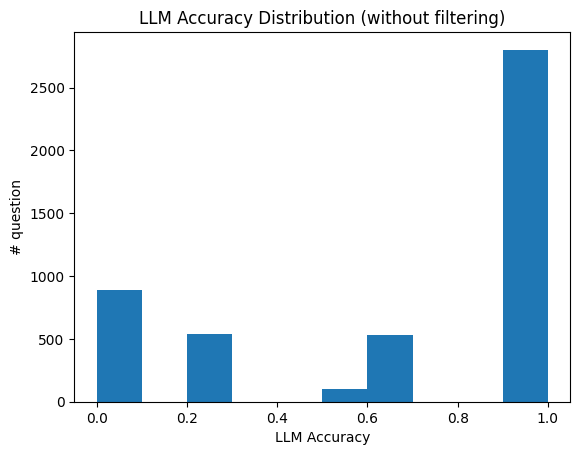

In [46]:
plt.hist(eos_sft_df["llm_accuracy"])
plt.xlabel("LLM Accuracy")
plt.ylabel("# question")
plt.title("LLM Accuracy Distribution (without filtering)")

In [47]:
len(eos_sft_df["answer"].to_list())

4856

In [48]:
vars.GPT_4_TOKENIZER("Writers, calligraphers, enthusiasts, professionals")

[54, 32929, 11, 1650, 54967, 388, 11, 43448, 11, 15749]

In [49]:
[a for a in eos_sft_df_filtered["answer"].to_list() if len(a) == 96]

['Destruction of the World Trade Center and Pentagon, mass casualties, and the War on Terror began']

In [50]:
[a for a in eos_sft_df_filtered["answer"].to_list() if len(vars.GPT_4_TOKENIZER(str(a))) >= 10]

['Christian (Anglican/Episcopalian)',
 'Christianity (Catholicism, then Protestantism)',
 'Colombey-les-Deux-Églises, France',
 'Woolsthorpe, Lincolnshire, England',
 'Gwanak-gu, Seoul, South Korea',
 'Ingrid Newkirk and Alex Pacheco',
 'Thomas Edison, Charles A. Coffin, Elihu Thomson, Edwin J. Houston',
 'Steve Jobs, Steve Wozniak, and Ronald Wayne',
 'Robert Wood Johnson, James Wood Johnson, and Edward Mead Johnson',
 'Pharmaceuticals, medical devices, consumer health products',
 'Navigators, hikers, sailors, surveyors',
 'Military, emergency services, law enforcement, executives, media',
 'Commuters, recreational riders, athletes, delivery workers',
 'Students, teachers, engineers, accountants, scientists',
 'Bell Labs (Daryl Chapin, Calvin Fuller, Gerald Pearson)',
 '1605 (Part I), 1615 (Part II)',
 'Carnivorous: fish, birds, mammals, reptiles, amphibians',
 'Omnivorous; eats plants, insects, and carrion',
 'Leaves, shoots, fruits, and flowers of trees',
 'Crustaceans, mollusks, al

In [52]:
# [a for a in eos_sft_df["answer"].to_list() if len(str(a)) == 30]

Text(0.5, 1.0, 'Answer Length Distribution (without filtering)')

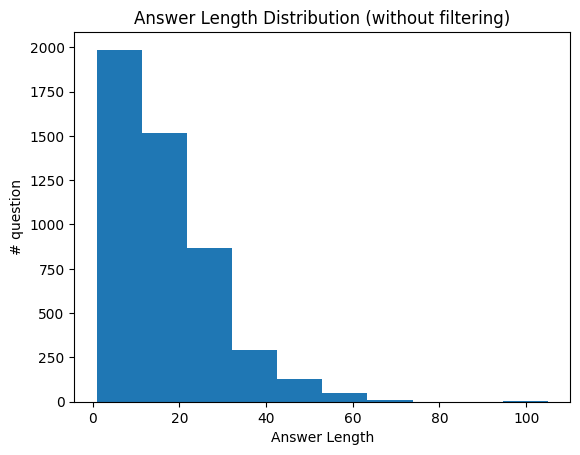

In [53]:
plt.hist([float(len(str(a))) for a in eos_sft_df["answer"].to_list()])
plt.xlabel("Answer Length")
plt.ylabel("# question")
plt.title("Answer Length Distribution (without filtering)")

In [122]:
eos_entity_type2count = {}
eos_entity_type2acc = {}
eos_entity_type2length = {}
eos_template2entity_names = defaultdict(list)

for i, d in eos_sft_df_filtered.iterrows():
    if d["entity_type"] not in eos_entity_type2count:
        eos_entity_type2count[d["entity_type"]] = defaultdict(int)
        eos_entity_type2acc[d["entity_type"]] = defaultdict(int)
        eos_entity_type2length[d["entity_type"]] = defaultdict(int)
        
    eos_entity_type2count[d["entity_type"]][d["template"]] += 1
    eos_template2entity_names[d["template"]].append(d["entity_name"])
    eos_entity_type2acc[d["entity_type"]][d["template"]] += d["llm_accuracy"]
    eos_entity_type2length[d["entity_type"]][d["template"]] += len(vars.GPT_4_TOKENIZER(str(d["answer"]).strip()))
        

In [178]:
# bad_question_templates = ["How many children did {person} have?", "What language family does {language} belong to?", "What is the national flower of {country}?", "When did {country} join the United Nations?", "What triggered {event}?", "What is the national anthem of {country} called?", "What is the date of {country}’s national day or independence day?", "What is the founding year of {country}?", "What legal system does {country} use?", "Which side is considered to have \"won\" {event}?", "What is the diet of {species}?"]
bad_question_templates = []
bad_entity_types = []

In [179]:
# eos_template2entity_names

In [180]:
counts = []
spotcheck_df_content = []
count_threshold = 0
entity_type2template_count = defaultdict(int)


for entity_type in eos_entity_type2count.keys():
    if entity_type in bad_entity_types:
        continue
    print(entity_type)
    for template in eos_entity_type2count[entity_type].keys():
        if template in bad_question_templates:
            continue
    
        acc_sum = eos_entity_type2acc[entity_type][template]
        count = eos_entity_type2count[entity_type][template]
        counts.append(count)
        
        acc = acc_sum / count
        spotcheck_df_content.append({
            "entity_type": entity_type,
            "template": template,
            "count": count,
            "accuracy": acc,
        })
        if count > count_threshold:
            entity_type2template_count[entity_type] += 1
            print(template, ":", acc, f"(count={count})")
    print("===" * 20)

Person
How many children did {person} have? : 0.9411764705882353 (count=17)
What is the religion of {person}? : 0.9262295081967216 (count=61)
What language was primarily spoken by {person}? : 0.9800000000000001 (count=80)
What occupation is {person} most well-known for? : 0.9102272727272728 (count=88)
What year did {person} pass away? : 1.0 (count=81)
What year was {person} born? : 1.0 (count=78)
Where did {person} die? : 0.9596153846153849 (count=52)
Where was the birthplace of {person}? : 0.9384615384615387 (count=65)
Organization
In what year was {organization} established? : 0.993421052631579 (count=76)
Where is the headquarters of {organization} located? : 0.9902173913043479 (count=92)
Where was {organization} established? : 0.9833333333333335 (count=90)
Who established {organization}? : 0.9054054054054054 (count=37)
What is the primary field or industry of {organization}? : 0.9009615384615388 (count=104)
What primary service or product does {organization} provide? : 0.88240740740

In [181]:
from itertools import combinations

def find_largest_intersection_at_least_m_sets(sets, m):
    """
    Find the largest intersection set using at least m sets from the given list of K sets.
    
    Args:
        sets: A list of sets, each containing elements
        m: Minimum number of sets to use for the intersection
    
    Returns:
        A tuple containing:
        - The largest intersection set
        - A list of indices of the sets that produce this largest intersection
    """
    if not sets or m <= 0 or m > len(sets):
        return set(), []  # Invalid input
    
    max_intersection_size = -1
    max_intersection_set = set()
    max_intersection_indices = []
    
    # Try finding the largest intersection with exactly j sets where j ranges from m to K
    for j in range(m, len(sets) + 1):
        # Try all combinations of j sets from the K sets
        for indices in combinations(range(len(sets)), j):
            # Calculate the intersection of the selected j sets
            selected_sets = [sets[i] for i in indices]
            intersection = set.intersection(*selected_sets)
            
            # Update maximum if this intersection is larger
            if len(intersection) > max_intersection_size:
                max_intersection_size = len(intersection)
                max_intersection_set = intersection
                max_intersection_indices = list(indices)
    
    return max_intersection_set, max_intersection_indices

In [182]:
set_list = [set(eos_template2entity_names[template]) for template in entity_type2templates["Person"]]

largest_overlap, set_ids = find_largest_intersection_at_least_m_sets(set_list, 5)
print(len(largest_overlap), len(set_ids), )

41 5


In [183]:
sanity_check_set = set_list[set_ids[0]]
for i in range(1, len(set_ids)):
    sanity_check_set = sanity_check_set.intersection(set_list[set_ids[i]])
len(sanity_check_set)

41

In [195]:
max_rel_config = dict([
    ("Person", 6),
    ("Event", 5),
    ("Species", 5),
    ("Language", 5),
    ("Organization", 5),
    ("Creative Work", 6),
    ("Country", 8),]
)

In [196]:
max_entity_config = [
    ("Person", 4),
    ("Event", 4),
    ("Species", 4),
    ("Language", 4),
    ("Organization", 4),
    ("Creative Work", 4),
    ("Country", 4),
]

In [197]:
eos_sft_df_filtered.columns

Index(['id', 'question_type', 'template', 'entity_name', 'entity_type',
       'input', 'stage', 'question', 'answer', 'predicted_answer_idx',
       'predicted_answer', 'exact_match', 'llm_accuracy'],
      dtype='object')

In [199]:
prefinalized_df = pd.concat(prefinalized_df_content)

Text(0.5, 1.0, 'Answer Length Distribution (after filtering)')

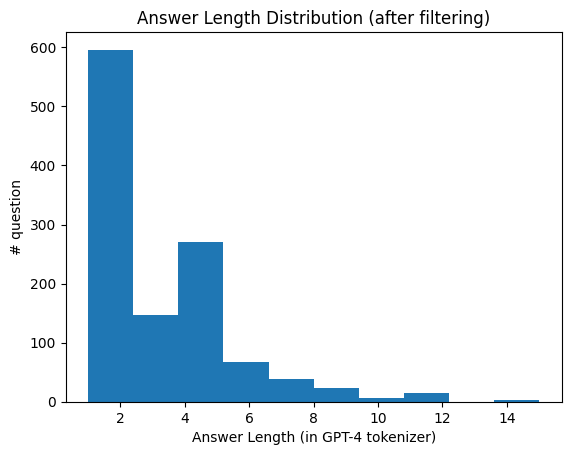

In [208]:
plt.hist([float(len(vars.GPT_4_TOKENIZER(str(a)))) for a in prefinalized_df["answer"].to_list()])
plt.xlabel("Answer Length (in GPT-4 tokenizer)")
plt.ylabel("# question")
plt.title("Answer Length Distribution (after filtering)")

In [201]:
float()

0.0

In [203]:
spotcheck_df_content = []
entity_spotcheck_df_content = []

for (entity_type, template), sub_df in prefinalized_df.groupby(["entity_type", "template"]):
    # pass
    acc = np.mean(sub_df["llm_accuracy"].to_list())
    length = float(np.mean([len(vars.GPT_4_TOKENIZER(a)) for a in sub_df["answer"].to_list()]))
    count = len(sub_df)
    # counts.append(count)
    rand_idx = np.random.randint(len(sub_df))
    for i, r in sub_df.iterrows():
        entity_spotcheck_df_content.append({
            "entity_type": entity_type,
            "entity_name": r["entity_name"],
        })
    
    spotcheck_df_content.append({
        "entity_type": entity_type,
        "template": template,
        "# entity": count,
        "avg_llm_accuracy": acc,
        "avg_answer_len (in GPT4 tokens)": length,
        "example_question": sub_df.iloc[rand_idx]["question"],
        "example_answer": sub_df.iloc[rand_idx]["answer"],
        "example_prediction": sub_df.iloc[rand_idx]["predicted_answer"],
    })

In [204]:
spotcheck_df = pd.DataFrame(spotcheck_df_content)
entity_spotcheck_df = pd.DataFrame(entity_spotcheck_df_content).drop_duplicates()
spotcheck_df = spotcheck_df.set_index(["entity_type", "template"], drop=True)
entity_spotcheck_df = entity_spotcheck_df.set_index(["entity_type",], drop=True)

In [206]:
spotcheck_df.to_excel(f"/u/zliu/datastor1/mend/spotcheck/spotcheck_df_curated_v1_rel.xlsx", index=True)

In [207]:
entity_spotcheck_df
entity_spotcheck_df.to_excel(f"/u/zliu/datastor1/mend/spotcheck/spotcheck_df_curated_v1_entity.xlsx", index=True)

In [610]:
# Counter(eos_sft_df_filtered[eos_sft_df_filtered.apply(lambda row: row["template"] == "Where is {species} primarily found?", axis=1)]["answer"])

In [ ]:
# spotcheck_df = pd.DataFrame(spotcheck_df_content)

In [611]:
# template_count_threshold = 1

In [ ]:
# print(f"# entity: {count_threshold}", f"# template: {template_count_threshold}", )
# len([k for k, v in entity_type2template_count.items() if v >= template_count_threshold])

# entity: 40 # template: 1


16

In [308]:
[k for k, v in entity_type2template_count.items() if v >= template_count_threshold]

['Historical Figure',
 'Business Figure',
 'Book',
 'Language',
 'Company',
 'Non-profit Organization',
 'University',
 'Invention',
 'Artwork',
 'Film',
 'Song',
 'Historical Event',
 'Software',
 'Species',
 'Author',
 'Country']